In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
cv_data_usa = pd.read_csv('cv-dev-usa.csv', parse_dates=["Date"], index_col="Date").dropna()
cv_data_world = pd.read_csv('cv-dev-world.csv', parse_dates=["Date"], index_col="Date").dropna()

cv_data = cv_data_usa


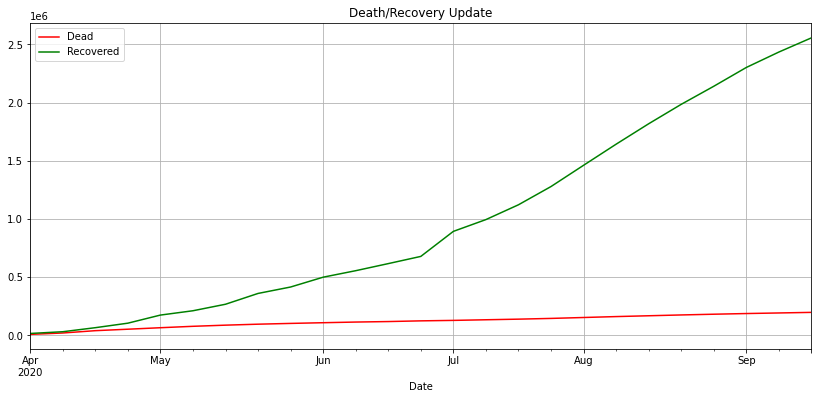

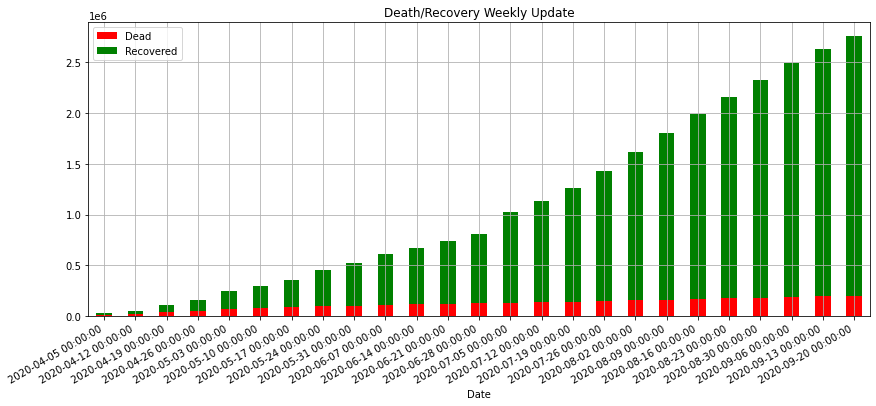

In [13]:
dead = cv_data.Dead
recovered = cv_data.Recovered

df = (pd.DataFrame({"Dead":dead
                   , "Recovered" : recovered
                  }
                  , index=cv_data.index)
          .resample("1W")
          .max()
     )

df.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , color = ['red', 'green']
        , title = "Death/Recovery Update"
        )
# Weekly
df.resample("1W").max().plot(kind='bar'
        , stacked=True
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , align = 'center'
        , color = ['red', 'green']
        , title = "Death/Recovery Weekly Update"
        )
plt.gcf().autofmt_xdate()
plt.show()



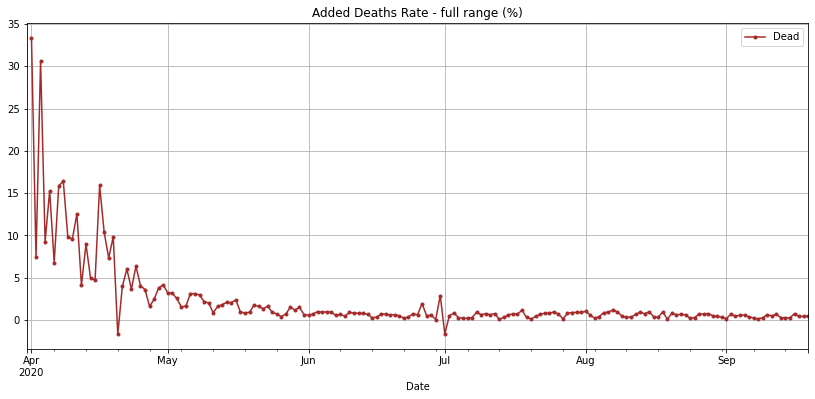

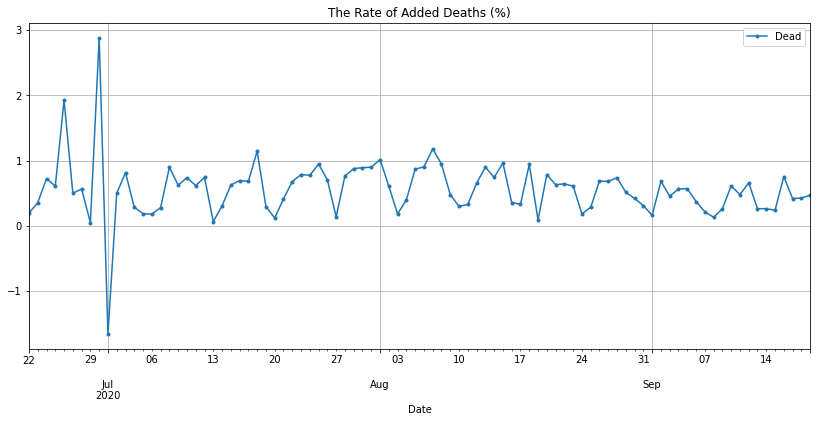

In [14]:



# plt.figure(num=None, figsize=(14,6), dpi=80, facecolor='#dddddd', edgecolor='k')
def growth_pcnt(ser): 
    return (ser - ser.shift(1)) / ser * 100

df = pd.DataFrame(growth_pcnt(cv_data.Dead), index=cv_data.index)
df.plot(
    kind = 'line'
    , title = 'Added Deaths Rate - full range (%)'
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
    , color = ['brown']
)

df[-90:].plot(
    kind = 'line'
    , title = 'The Rate of Added Deaths (%)'
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
#     , color = ['brown']
)
plt.show()



                   0
Date                
2020-09-17  7.230419
2020-09-18  7.219899
2020-09-19  7.208946


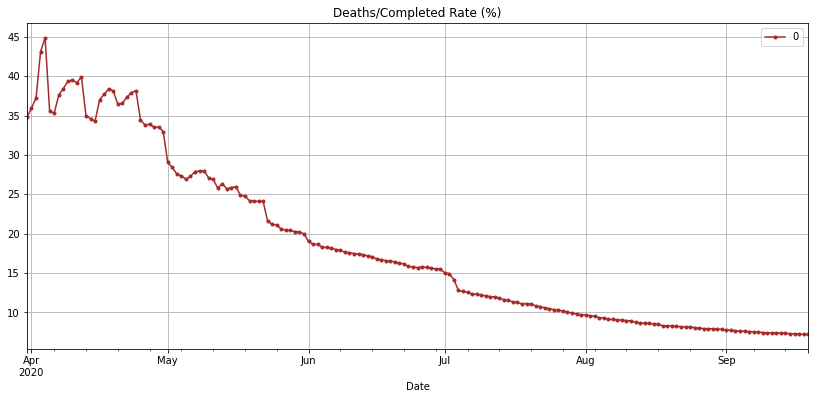

In [15]:
# Death rate in completed cases
death_rate = pd.DataFrame(dead / (cv_data.Dead + cv_data.Recovered) * 100.0
                          , index=cv_data.index)
death_rate.plot(
    kind = 'line'
    , title = 'Deaths/Completed Rate (%)'
    , figsize=(14, 6)
    , grid = True
    , style = '.-'
    , color = ['brown']
)
print(death_rate.tail(3))
plt.show()

Date
2020-09-15     940.0
2020-09-16    1600.0
2020-09-17     409.0
2020-09-18     167.0
2020-09-19     582.0
Name: Dead, dtype: float64


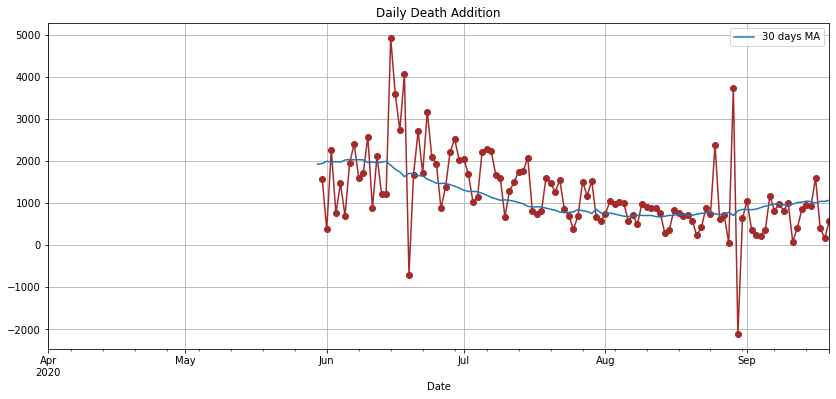

In [30]:
# Deaths daily additions
df1 = (cv_data.Dead - cv_data.Dead.shift(1)).dropna()
df = df1.shift(60).dropna()
print(df.tail())
df.plot(
    title="Daily Death Addition"
    , figsize=(14, 6)
    , grid = True
    , color = ['brown']
    , style = '-o'
)
df1.shift(30).rolling(30).mean().plot(grid=True, legend=True, label="30 days MA")
plt.show()


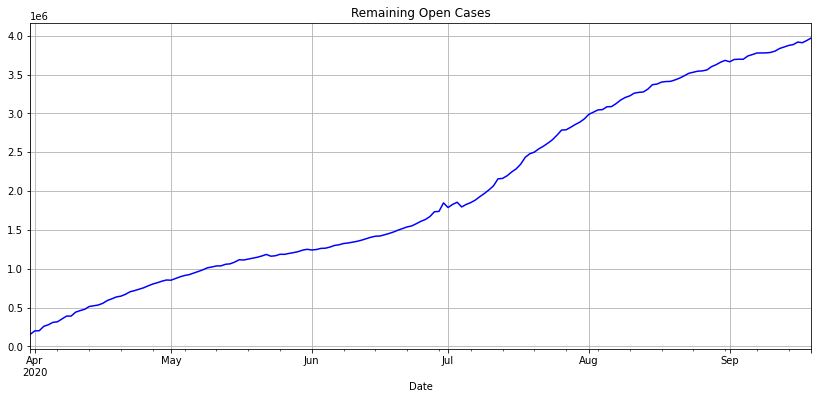

In [17]:
# Remaining open cases
df = (cv_data.Confirmed - cv_data.Dead - cv_data.Recovered).dropna()
df.plot(
    title="Remaining Open Cases"
    , figsize=(14, 6)
    , grid = True
    , color = ['blue']
)


Date
2020-09-15    11175.0
2020-09-16    32329.0
2020-09-17    -8346.0
2020-09-18    29226.0
2020-09-19    33312.0
dtype: float64


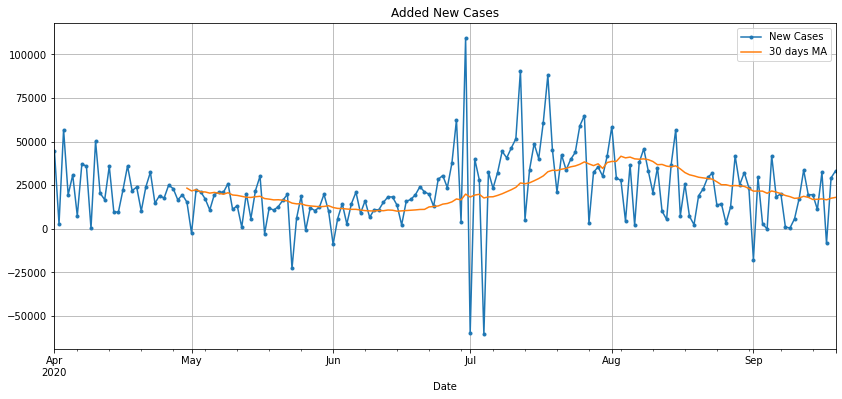

In [18]:
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd
# cv_data = pd.read_csv('cv-dev-usa.csv', parse_dates=True, index_col=0)

confirmed_new = (cv_data.Confirmed - cv_data.Confirmed.shift(1)).dropna()
dead_new = (cv_data.Dead - cv_data.Dead.shift(1)).dropna()
recovered_new = (cv_data.Recovered - cv_data.Recovered.shift(1)).dropna()

growth = pd.Series((confirmed_new - (dead_new + recovered_new)).array
                   , index=cv_data.index[1:]).dropna()

growth.plot(figsize=(14, 6)
            , title="Added New Cases"
            , legend=True
            , label="New Cases"
            , style='.-')
# growth.rolling(10).mean().plot(grid=True, legend=True, label="10 days MA")
# growth.rolling(20).mean().plot(grid=True, legend=True, label="20 days MA")
growth.rolling(30).mean().plot(grid=True, legend=True, label="30 days MA")
print(growth.tail(5))
plt.show()


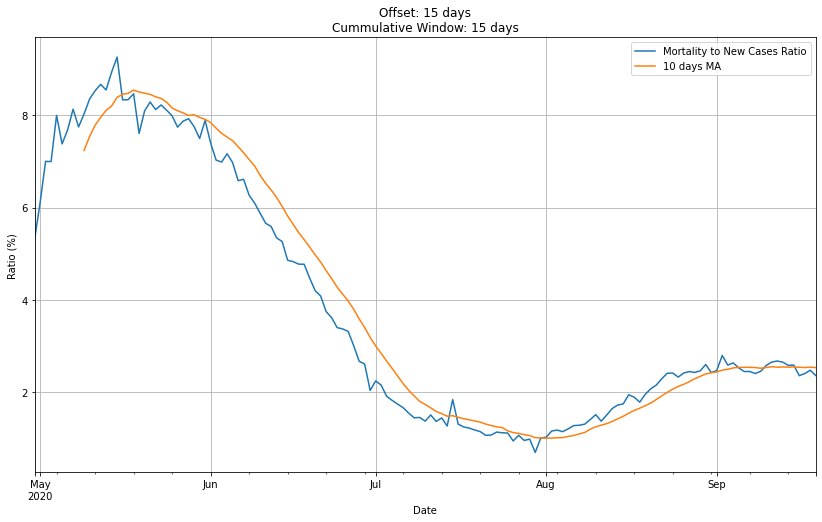

Date
2020-09-15    2.587524
2020-09-16    2.357863
2020-09-17    2.403761
2020-09-18    2.475228
2020-09-19    2.360761
dtype: float64


In [19]:
# New Cases -> Deathes Correlation
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd

# Mortality to confirmed after offsetDays and for cumm_wnd_days

def mortalityToNewCasesRatio(cumm_wnd_days : int
                             , offset_days : int):
    confirmed = cv_data.Confirmed
    dead = cv_data.Dead
    # accumulate total confirmed during that "cummDaysWindow" days
    cumm_conf = confirmed - confirmed.shift(cumm_wnd_days)

    # death accumulate for same windows but "offset_days" later
    deadOffset = dead.shift(offset_days)
    cummDead = deadOffset -  deadOffset.shift(cumm_wnd_days)

    res = cummDead * 100 / cumm_conf
    return res

    
def plot_cases_mortality_chart(**kwargs):
    cumm_wnd_days = kwargs["window_size"]
    days_shift = kwargs["offset_days"]
    maDays = kwargs["ma_days"] if "ma_days" in kwargs else 5

    ratio = mortalityToNewCasesRatio(cumm_wnd_days
                                    , days_shift).dropna()
    ratio.plot(title=f"Offset: {days_shift} days\nCummulative Window: {cumm_wnd_days} days"
           , figsize=(14, 8)
           , grid=True
           , legend=True
           , label="Mortality to New Cases Ratio"
           )

    ratio.rolling(maDays).mean().plot(grid=True
                                  , label="{} days MA".format(maDays)
                                  , legend=True)
    plt.ylabel("Ratio (%)")
    plt.show()
    print(ratio.tail(5))

# --- main
# # for cum_wnd_days in [15, 20, 30]:
# #     plot_correlation_chart(confirmed, dead, cum_wnd_days)

cum_wnd_days = 15
plot_cases_mortality_chart(window_size=cum_wnd_days
                           , offset_days=cum_wnd_days 
                           , ma_days=10)




max_corr_value=0.9003099090520605 max_wnd_days=40 max_shift_days=91


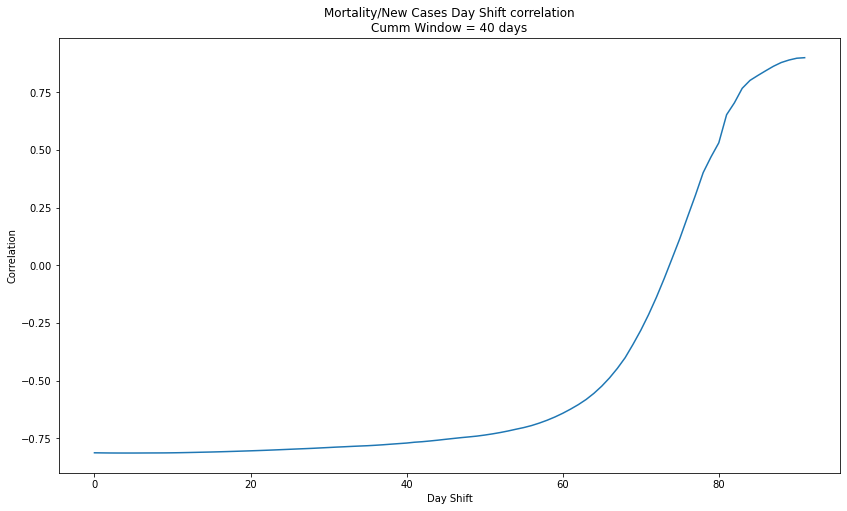

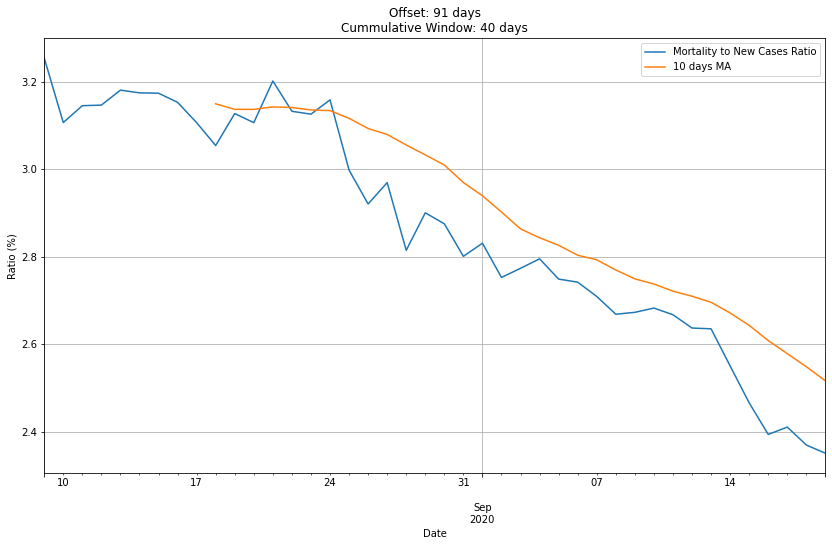

Date
2020-09-15    2.466298
2020-09-16    2.394095
2020-09-17    2.410933
2020-09-18    2.369938
2020-09-19    2.351145
dtype: float64


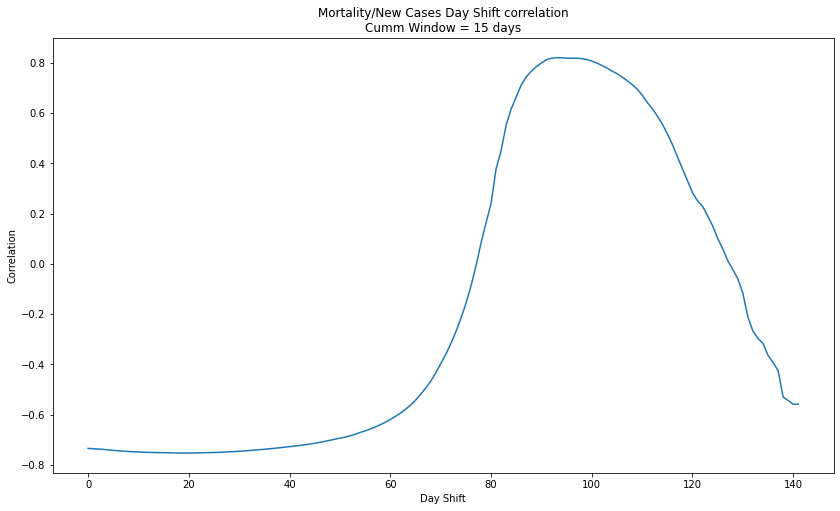

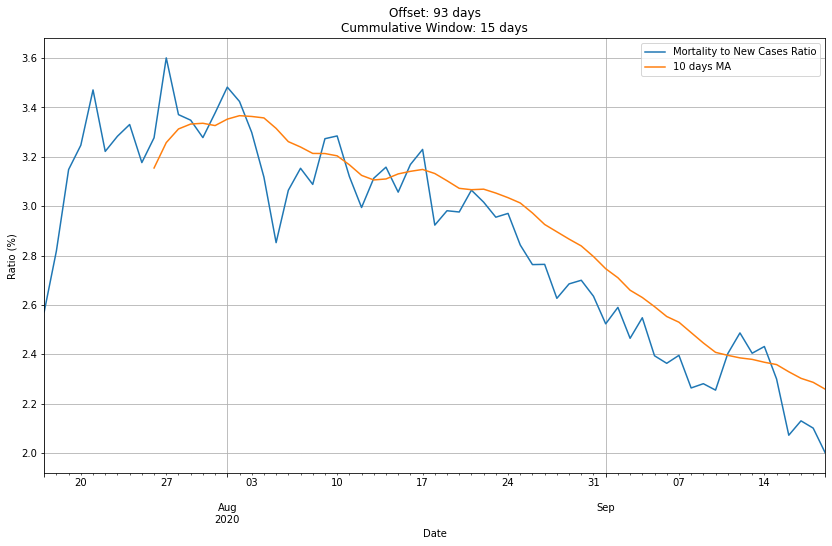

Date
2020-09-15    2.300167
2020-09-16    2.072503
2020-09-17    2.130702
2020-09-18    2.101250
2020-09-19    1.999528
dtype: float64


In [20]:
def calcCorrelation(cumm_wnd_days : int
                    , days_shift : int):
    confirmed = cv_data.Confirmed
    dead = cv_data.Dead
    # accumulate total confirmed during that "cumm_wnd_days" days
    cumm_conf = (confirmed - confirmed.shift(cumm_wnd_days)).shift(days_shift).dropna()

    # death accumulate for same windows but "offsetDays" later
    dead_shift = dead.shift(days_shift)
    cumm_dead = (dead_shift -  dead_shift.shift(cumm_wnd_days)).dropna()

    ratio = (cumm_dead * 100 / cumm_conf).dropna()
    
    corr=ratio.corr(cumm_conf)
    return corr

def correlation(cum_wnd_days: int):
    num_observ_days = len(cv_data.index) - 2 *cum_wnd_days
    after_days_arr=range(1, num_observ_days)
    
    corr_arr = [calcCorrelation(cum_wnd_days, after_days) 
               for after_days in after_days_arr]
    return pd.Series(corr_arr)
    
def plot_correlation_chart(corr : pd.DataFrame
                          , cum_wnd_days: int):
    corr.plot(figsize=(14, 8)
             , title=f"Mortality/New Cases Day Shift correlation\nCumm Window = {cum_wnd_days} days"
             , legend=False, label="Correlation") 
    plt.ylabel("Correlation")
    plt.xlabel("Day Shift")
    plt.show()


def max_correlation_by_window(cumm_wnd_days):
    corr = correlation(cumm_wnd_days).dropna()
    corr_days=corr.idxmax()
    corr_val=corr[corr_days]
    return (cumm_wnd_days, corr_days, corr_val)
    
    
data = [max_correlation_by_window(cumm_wnd_days) for cumm_wnd_days in range(1, 60)]
df = pd.DataFrame(data, columns=["WndDays", "ShiftDays", "CorrValue"])

max_corr_idx = df.CorrValue.idxmax()
wnd_size=df.WndDays[max_corr_idx]
shift_days=df.ShiftDays[max_corr_idx]
print(f"max_corr_value={df.CorrValue[max_corr_idx]} max_wnd_days={df.WndDays[max_corr_idx]} max_shift_days={df.ShiftDays[max_corr_idx]}") 
plot_correlation_chart(correlation(wnd_size).dropna(), wnd_size)
plot_cases_mortality_chart(window_size=wnd_size
                           , offset_days=shift_days # taking maximal correlation value
                           , ma_days=10)




corr = correlation(15)
plot_correlation_chart(corr, 15)
plot_cases_mortality_chart(window_size=15
                           , offset_days=corr.idxmax() # taking maximal correlation value
                           , ma_days=10)

